In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats

In [65]:
np.random.seed(42)

In [69]:
table2_df = pd.read_csv('../Tables/T2:DA_Seasons_by_Day.csv')
table2_df.drop('Unnamed: 0', axis=1, inplace=True)
tbl2_alt = table2_df.drop(0, axis=0)
table2_df.X = table2_df.X.astype(int)
table2_df.Y = table2_df.Y.astype(int)
table2_df.head()

,X,Y,Season
0,1,303,Winter
1,1,203,Winter
2,1,179,Winter
3,1,176,Winter
4,1,170,Winter


In [78]:
ts_df = pd.read_csv('../Data/Mart2/fix.csv')
ts_df = ts_df[['Incident Date', 'ORI']]
ts_df['Month'] = ts_df['Incident Date'].str.split('/', expand=True)[0]
ts_df['Month'] = ts_df.Month.astype(int)
ts_df.ORI = ts_df.ORI.astype(int)
ts_df.rename({'ORI':"Incident Frequency"}, axis=1, inplace=True)
ts_df.head()

,Incident Date,Incident Frequency,Month
0,1/1/20,303,1
1,1/10/20,161,1
2,1/11/20,203,1
3,1/12/20,178,1
4,1/13/20,148,1


In [92]:
admin_df = pd.read_csv('../Data/2020 Domestic Violence - Administrative Data.csv', encoding='ISO-8859-1',skiprows=7)
def change_date_Y_y(x):
    try:
        dt = datetime.strptime(x, "%m/%d/%y")
    except ValueError:
        dt = datetime.strptime(x, "%m/%d/%Y")
    return dt.strftime("%m/%d/%y")

def month_to_season(x):
    if x in [1,2,12]:
        return 'Winter'
    elif x in [3,4,5]:
        return 'Spring'
    elif x in [6,7,8]:
        return 'Summer' 
    else:
        return 'Fall'
    return 

def day_of_week(x):
    dow = datetime.strptime(x, "%m/%d/%y")
    return dow.strftime("%A")

def week_of_year(x):
    woy = datetime.strptime(x, "%m/%d/%y")
    return woy.isocalendar()[1]

# specfically want to get rid of decimal places if they occur, and fix scientific notation 
# which is not recognized as the same from one table to another in long form. Long form is searchable in the og csvs, so
# keep long form
def change_incNum_long_noDec(x):
    # will need to fix this first
    # fix scientific notation to long form, ex: other ref '2.02007E+11' -> '20200700000'
    if '+' in x:
        x, n = x.split('E+')
        # mult by power of 10, then convert back to str w/o '.0' tail
        x = str(float(x)*10**int(n))[:-2]
    # drop decimals if present, ex: admin ref '202001000000.00' -> '202001000000'
    return x.split('.')[0]

admin_df['Incident Date'] = admin_df['Incident Date'].apply(change_date_Y_y)
admin_df['Incident Number'] = admin_df['Incident Number'].apply(change_incNum_long_noDec)
admin_df['Incident_Key'] = admin_df['ORI'] + '<>' + admin_df['Incident Number'] + '<>' + admin_df['Incident Date']
admin_df.drop_duplicates('Incident_Key', inplace=True)
admin_df.shape

(59976, 10)

In [88]:
ts_df['Incident Date'] = ts_df['Incident Date'].apply(change_date_Y_y)
ts_df['Season'] = ts_df.Month.apply(month_to_season)
ts_df['Week of Year'] =ts_df['Incident Date'].apply(week_of_year)
ts_df.head()

,Incident Date,Incident Frequency,Month,Season,Week of Year
0,01/01/20,303,1,Winter,1
1,01/10/20,161,1,Winter,2
2,01/11/20,203,1,Winter,2
3,01/12/20,178,1,Winter,2
4,01/13/20,148,1,Winter,3


In [94]:
table2_revised = ts_df.sort_values('Incident Date', ascending=True)
table2_revised.reset_index(drop=True, inplace=True)
table2_revised['Weekday'] = table2_revised['Incident Date'].apply(day_of_week)
table2_revised.to_csv('../Tables/T2:DV_Seasons_by_Day.csv')
table2_revised.head()

,Incident Date,Incident Frequency,Month,Season,Week of Year,Weekday
0,01/01/20,303,1,Winter,1,Wednesday
1,01/02/20,134,1,Winter,1,Thursday
2,01/03/20,159,1,Winter,1,Friday
3,01/04/20,155,1,Winter,1,Saturday
4,01/05/20,161,1,Winter,1,Sunday


In [124]:
to_calc = {
    'count()':'Frequency',
    'mean()': 'Average',
    'std()':'StDev',
}
X = table2_revised.groupby(['Weekday']).sum()
X.rename({'Incident Frequency':'Weekday DV Yearly Total'}, axis=1, inplace=True)
Y = table2_revised.groupby(['Weekday']).mean()
Y.rename({'Incident Frequency':'Weekday Average over Year'}, axis=1, inplace=True)
Z = table2_revised.groupby(['Weekday']).std()
Z.rename({'Incident Frequency':'Weekday StDev over Year'}, axis=1, inplace=True)
wkdy_summary = pd.concat([X,Y,Z], axis=1)
wkdy_summary = wkdy_summary[['Weekday DV Yearly Total', 'Weekday Average over Year', 'Weekday StDev over Year']]
wkdy_summary.reset_index(drop=False, inplace=True)
wkdy_summary = wkdy_summary.reindex(index=[3,1,5,6,4,0,2])
wkdy_summary.reset_index(drop=True, inplace=True)
wkdy_summary.to_csv('../Tables/Day_of_Week_desc.csv')

In [38]:
admin_df.drop(['Report Date Indicator','Incident Clearance','Exceptional Clearance Date','Address','Cargo Theft'], axis=1,inplace=True)
by_day_df = admin_df.groupby(['Incident Date']).count()
by_day_df.reset_index(drop=False, inplace=True)
by_day_df['Month'] = by_day_df['Incident Date'].str.split('/', expand=True)[0]
by_day_df.Month = by_day_df.Month.astype(int)
by_day_df.head()

,Incident Date,ORI,Incident Number,Hour of Day,Incident_Key,Month
0,01/01/20,304,304,304,304,1
1,01/02/20,135,135,135,135,1
2,01/03/20,159,159,159,159,1
3,01/04/20,156,156,156,156,1
4,01/05/20,162,162,162,162,1


In [40]:
by_day_df.loc[by_day_df.Month == 1]

,Incident Date,ORI,Incident Number,Hour of Day,Incident_Key,Month
0,01/01/20,304,304,304,304,1
1,01/02/20,135,135,135,135,1
2,01/03/20,159,159,159,159,1
3,01/04/20,156,156,156,156,1
4,01/05/20,162,162,162,162,1
5,01/06/20,130,130,130,130,1
6,01/07/20,145,145,145,145,1
7,01/08/20,155,155,155,155,1
8,01/09/20,154,154,154,154,1
9,01/10/20,162,162,162,162,1


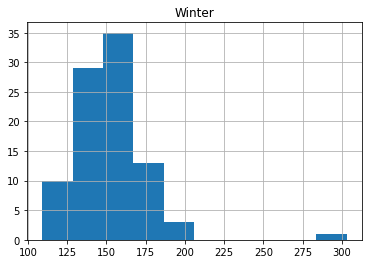

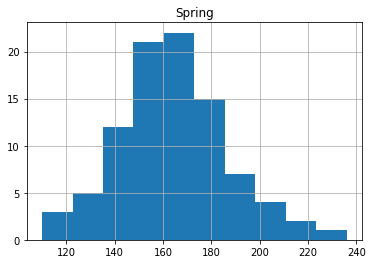

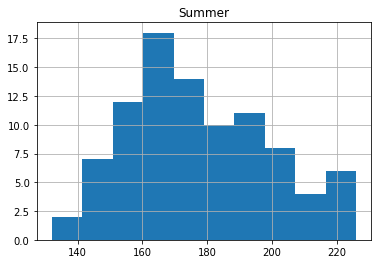

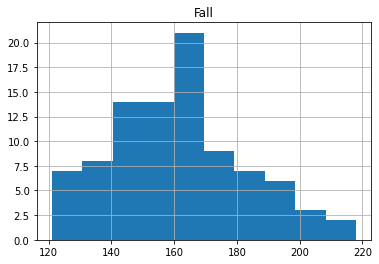

In [13]:
for season in table2_df.Season.unique():
    table2_df.loc[table2_df.Season == season].hist('Y')
    plt.title(season)

In [19]:
# comparing Winter-Mod descriptive statistics w/o January 1 outlier
tbl2_alt.loc[tbl2_alt.Season == 'Winter'].Y.describe()

count     90.000000
mean     150.455556
std       18.232063
min      109.000000
25%      137.250000
50%      151.000000
75%      161.000000
max      203.000000
Name: Y, dtype: float64

In [64]:
desc_df = pd.read_csv('../Tables/T2_Summary.csv')
desc_df.head()


,Unnamed: 0,Winter,Winter-Mod,Spring,Summer,Fall
0,count,91.000000,90.000000,92.000000,92.000000,91.000000
1,mean,152.131868,150.455556,163.891304,177.641304,161.362637
2,std,24.174922,18.232063,22.817699,21.732430,21.677185
3,min,109.000000,109.000000,110.000000,132.000000,121.000000
4,25%,137.500000,137.500000,150.000000,161.000000,145.500000


In [66]:
# checking for normality with Shapiro-Wilcox & Kolmogorov-Smirnov
norm_results = {
    'Season':[],
    'Shapiro-Wilcox':[],
    'SW p-value':[],
    'SW Normality':[],
    'Kolmogorov-Smirnov':[], # Compared to a random normal curve with matching mu, sig per Season 
    'KS p-value':[],
    'KS Normality':[],
}
for season in table2_df.Season.unique():
    # getting Shapiro-Wilcox Results
    SW = stats.shapiro(table2_df.loc[table2_df.Season == season].Y)
    print(season, '\n', SW)
    norm_results['Season'].append(season)
    norm_results['Shapiro-Wilcox'].append(SW[0])
    norm_results['SW p-value'].append(SW[1])
    if SW[1] >= 0.05:
        norm_results['SW Normality'].append('Fail to Reject')
    else:
        norm_results['SW Normality'].append('Reject Null')
    # getting Kolmogorov-Smirnov results
    n, mu, sig = desc_df[season][:3]
    s = np.random.normal(mu, sig, 500)
    KS = stats.kstest(table2_df.loc[table2_df.Season == season].Y, cdf=s)
    print(KS)
    norm_results['Kolmogorov-Smirnov'].append(KS[0])
    norm_results['KS p-value'].append(KS[1])
    if KS[1] >= 0.05:
        norm_results['KS Normality'].append('Fail to Reject')
    else:
        norm_results['KS Normality'].append('Reject Null')

SW = stats.shapiro(tbl2_alt.loc[tbl2_alt.Season == 'Winter'].Y)
n, mu, sig = desc_df['Winter-Mod'][:3]
s = np.random.normal(mu, sig, 500)
KS = stats.kstest(tbl2_alt.loc[tbl2_alt.Season == 'Winter'].Y, cdf=s)
print('Winter-Mod\n', SW)
print(KS)
norm_results['Season'].append('Winter-Mod')
norm_results['Shapiro-Wilcox'].append(SW[0])
norm_results['SW p-value'].append(SW[1])
if SW[1] >= 0.05:
    norm_results['SW Normality'].append('Fail to Reject')
else:
    norm_results['SW Normality'].append('Reject Null')
norm_results['Kolmogorov-Smirnov'].append(KS[0])
norm_results['KS p-value'].append(KS[1])
if KS[1] >= 0.05:
    norm_results['KS Normality'].append('Fail to Reject')
else:
    norm_results['KS Normality'].append('Reject Null')

Winter 
 ShapiroResult(statistic=0.8068898916244507, pvalue=1.443257180433477e-09)
KstestResult(statistic=0.1221978021978022, pvalue=0.18377112279447655)
Spring 
 ShapiroResult(statistic=0.9807682037353516, pvalue=0.19274045526981354)
KstestResult(statistic=0.10017391304347827, pvalue=0.3878202015053178)
Summer 
 ShapiroResult(statistic=0.9680676460266113, pvalue=0.023432007059454918)
KstestResult(statistic=0.1466086956521739, pvalue=0.06320847344640537)
Fall 
 ShapiroResult(statistic=0.9859603047370911, pvalue=0.43925365805625916)
KstestResult(statistic=0.07969230769230769, pvalue=0.6771626218655061)
Winter-Mod
 ShapiroResult(statistic=0.9849006533622742, pvalue=0.38474002480506897)


In [68]:
df = pd.DataFrame(norm_results)
df.head()

,Season,Shapiro-Wilcox,SW p-value,SW Normality,Kolmogorov-Smirnov,KS p-value,KS Normality
0,Winter,0.806890,1.443257e-09,Reject Null,0.122198,0.183771,Fail to Reject
1,Spring,0.980768,1.927405e-01,Fail to Reject,0.100174,0.387820,Fail to Reject
2,Summer,0.968068,2.343201e-02,Reject Null,0.146609,0.063208,Fail to Reject
3,Fall,0.985960,4.392537e-01,Fail to Reject,0.079692,0.677163,Fail to Reject
4,Winter-Mod,0.984901,3.847400e-01,Fail to Reject,0.072222,0.791537,Fail to Reject


In [74]:
# creating a normal distribution with the same mean and stdev of season for comparisons
n, mu, sig = 500, 177.641304, 21.7324296
s = np.random.normal(mu, sig, n)

stats.kstest(table2_df.loc[table2_df.Season == 'Summer'].Y, cdf=s)

# checking states
p, f = 0, 0
for i in range(10000):
    x = 123456000 + i
    np.random.RandomState(np.random.MT19937(np.random.SeedSequence(x)))
    s = np.random.normal(mu, sig, n)
    R = stats.kstest(table2_df.loc[table2_df.Season == 'Summer'].Y, cdf=s)
    if R[1] >= 0.05:
        p += 1
    else:
        f += 1

print(f'After {p+f} simulations, Summer passes KS test {round(p/(p+f),2)*100}% of the time.')
print(f'Passes: {p},\nFails: {f}')


After 10000 simulations, Summer passes KS test 99.0% of the time.
Passes: 9918,
Fails: 82


In [80]:
# compare the results of the ANOVA and Kruskal-Wallace tests
# ANOVA, using Winter-Mod
# Styling follows TDS https://towardsdatascience.com/anova-tukey-test-in-python-b3082b6e6bda
keys = list(tbl2_alt.Season.unique())

values = []
for season in keys:
    values.append(list(tbl2_alt.loc[tbl2_alt.Season == season, 'Y']))

data = dict(zip(keys, values))

fvalue, pvalue = stats.f_oneway(data['Winter'], data['Spring'], data['Summer'], data['Fall'])
print(f"Results of ANOVA test:\n The F-statistic is: {fvalue}\n The p-value is: {pvalue}")
# pvalue < 0.05
print('The p-value is less 0.05, we have reason to believe the seasons have significantly different means.')

# Tukey for comparisons
from statsmodels.stats.multicomp import pairwise_tukeyhsd
comp = pairwise_tukeyhsd(endog=tbl2_alt.Y, groups=tbl2_alt.Season, alpha=0.05)
print(comp)

Results of ANOVA test:
 The F-statistic is: 25.321980158079533
 The p-value is: 6.863072737198794e-15
The p-value is less 0.05, we have reason to believe the seasons have significantly different means.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
  Fall Spring   2.5287 0.8512  -5.5608  10.6182  False
  Fall Summer  16.2787    0.0   8.1892  24.3682   True
  Fall Winter -10.9071 0.0034 -19.0412   -2.773   True
Spring Summer    13.75 0.0001   5.6826  21.8174   True
Spring Winter -13.4357 0.0001 -21.5478  -5.3237   True
Summer Winter -27.1857    0.0 -35.2978 -19.0737   True
------------------------------------------------------


In [7]:
# checking if figure 8 has significantly different rates per day
# null hypothesis: Weekdays are roughly equivalent in cases of DV
# expected per day should be total / 7 

# taken from preparing_data.ipynb
observed = [8515, 8132, 9311, 9646, 8008, 8090, 8169] # order: F, M, Sa, Su, Th, Tu, W
expected = [int(round(sum(observed)/7,0))] * 7

X, xfpvalue = stats.chisquare(f_obs=observed, f_exp=expected)
print(f'Chi-Squared Goodness of Fit Test\nStatistic: {X}\nP-value: {xfpvalue}\nReject null: {xfpvalue<0.05}')

Chi-Squared Goodness of Fit Test
Statistic: 304.7758681164504
P-value: 7.750540477529207e-63
Reject null: True
